In [725]:
import numpy as np
import pandas as pd
import h5py
import sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from statistics import mean
import scipy
from pathlib import Path

from radiometric.LUT import create_LUT_df, determine_reference, applyNUC_to_LUT

from NUC.NUC_functions import import_NUC, apply_NUC, get_slice, determine_slope
from NUC.NUC_functions import determine_dark, apply_DFC_to_df
from NUC.NUC_functions import pixel_registration

from matplotlib import cm
from scipy.optimize import curve_fit
import matplotlib.colors as colors


In [717]:
#Plotting Options
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 26

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams["font.family"] = "Times New Roman"

In [423]:
#choose filepath to desired data
path = '/Volumes/KESU/apr06/LUTS/'
#note cam definitions are flipped as of FLIRPY ffc fix 
cal_file2 =  '/Volumes/KESU/calibration_files/cam1pixel.h5'
cal_file1 =  '/Volumes/KESU/calibration_files/cam2pixel.h5'

In [607]:
waves= np.linspace(7,12,61)
temps = np.linspace(35,80,46)
temps

array([35., 36., 37., 38., 39., 40., 41., 42., 43., 44., 45., 46., 47.,
       48., 49., 50., 51., 52., 53., 54., 55., 56., 57., 58., 59., 60.,
       61., 62., 63., 64., 65., 66., 67., 68., 69., 70., 71., 72., 73.,
       74., 75., 76., 77., 78., 79., 80.])

In [426]:
#select ROI
ymin2 = 90; ymax2 = 150;
ymin1 = 120; ymax1 = 180;

FOV = 5.33 ;
HFOV = FOV/4;
angles = np.round(np.linspace(-HFOV,HFOV,ymax2-ymin2))

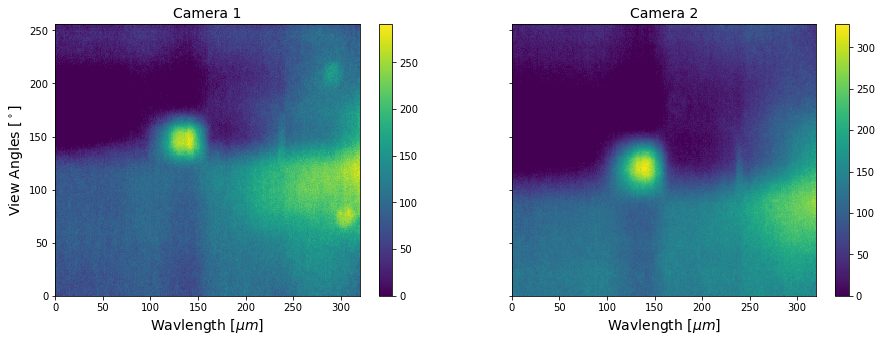

38.3

In [685]:
filename = path + '75C.h5'


with h5py.File(filename, "r") as file:
    image1 = np.mean(file['imgs1'][()],axis = 0)
    image2 = np.mean(file['imgs2'][()],axis = 0)
    s1 = np.std(file['imgs1'][()],axis = 0)
    s2 = np.mean(file['imgs2'][()],axis = 0)
    t2 = np.mean(file['temps2'][()],axis = 0)
    t1 = np.mean(file['temps1'][()],axis = 0)

c1 = (image1-np.mean(image1[125:175,25:75]))

c2 = (image2-np.mean(image2[100:150,25:75]))

r1 = np.mean(image1[100:150,25:75])

#plot test images, test appearance
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5),sharey = True)

p1 = axes[0].pcolormesh(c1,shading = 'auto',vmin = 0)
fig.colorbar(p1, ax=axes[0])
axes[0].set_title('Camera 1',fontsize = 14)
axes[0].set_ylabel('View Angles [$^\circ$]',fontsize = 14)
axes[0].set_xlabel('Wavlength [$\mu m$]',fontsize = 14)

p2 = axes[1].pcolormesh(c2,shading = 'auto',vmin = 0)
axes[1].set_title('Camera 2',fontsize = 14)
axes[1].set_xlabel('Wavlength [$\mu m$]',fontsize = 14)
fig.colorbar(p2, ax=axes[1])

plt.show()
t2

In [686]:
im1 = []
im2 = []
std1 = []
std2 = []
for t in temps:
    filename = path +str(round(t))+'C.h5'

    with h5py.File(filename, "r") as file:
        image1 = np.mean(file['imgs1'][()],axis = 0)
        image2 = np.mean(file['imgs2'][()],axis = 0)
        s1 = np.std(file['imgs1'][()],axis = 0)
        s2 = np.std(file['imgs2'][()],axis = 0)


    c1 = (image1-np.mean(image1[125:175,25:75]))
    c2 = (image2-np.mean(image2[100:150,25:75]))
    
    im1.append(c1)
    im2.append(c2)
    std1.append(s1)
    std2.append(s2)



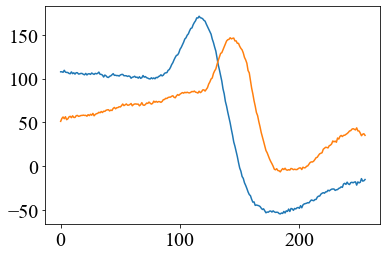

142

In [795]:
#Find location of 0 degree point
p2 = pixel_registration(im2[30],cal_file2,waves,0,256)
p1 = pixel_registration(im1[30],cal_file1,waves,0,256)
plt.plot(np.mean(p2,axis = 1))
plt.plot(np.mean(p1,axis = 1))
plt.show()

y1 = np.argmax(np.mean(p1,axis = 1))
y2 = np.argmax(np.mean(p2,axis = 1))
y1

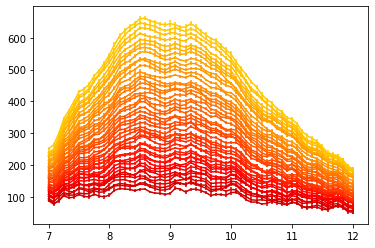

In [688]:
for t in range(len(temps)):
    p2 = pixel_registration(im2[t],cal_file2,waves,0,256)
    p1 = pixel_registration(im1[t],cal_file1,waves,0,256)
    s2 = pixel_registration(std2[t],cal_file2,waves,0,256)
    s1 = pixel_registration(std1[t],cal_file1,waves,0,256)


    plt.errorbar(waves,p2[y2]+p1[y1],yerr = np.sqrt(s2[y2]**2+s1[y1]**2),c=cm.hot(temps[t]/120))


plt.show()



In [689]:
responses = np.zeros([len(temps),len(waves)])
responses1 = np.zeros([len(temps),len(waves)])
responses2 = np.zeros([len(temps),len(waves)])
responses_err = np.zeros([len(temps),len(waves)])
responses_err1 = np.zeros([len(temps),len(waves)])
responses_err2 = np.zeros([len(temps),len(waves)])

for t in range(len(temps)):
    p2 = pixel_registration(im2[t],cal_file2,waves,0,256)
    p1 = pixel_registration(im1[t],cal_file1,waves,0,256)
    s2 = pixel_registration(std2[t],cal_file2,waves,0,256)
    s1 = pixel_registration(std1[t],cal_file1,waves,0,256)

    err = np.sqrt(s2[y2]**2+s1[y1]**2)
    responses[t]= p2[y2]+p1[y1]
    responses_err[t]= err
    
    responses1[t]= p1[y1]
    responses_err1[t]= s1[y1]
    responses2[t]= p2[y2]
    responses_err2[t]= s2[y2]


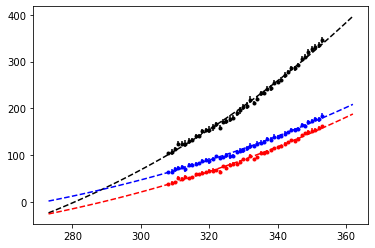

array([3.61863863e-08, 2.24165453e+02])

In [690]:
""" Fitting Function"""
def func(x, a, b):
    y = a*(x)**4 - b
    return y

ind = 3

x = temps + 273
y = responses[:,ind]
y1 = responses1[:,ind]
y2 = responses2[:,ind]
x2 = np.arange(0,90) +273

popt, pcov = curve_fit(func, x, y, sigma = responses_err[:,ind])
popt1, pcov1 = curve_fit(func, x, y1, sigma = responses_err1[:,ind])
popt2, pcov2 = curve_fit(func, x, y2, sigma = responses_err2[:,ind])

plt.plot(x2, func(x2, *popt1)+func(x2, *popt2), 'k--')
plt.plot(x2, func(x2, *popt1), 'b--')
plt.plot(x2, func(x2, *popt2),'r--')

plt.errorbar(x,y,yerr = responses_err[:,ind],fmt='.k')
plt.errorbar(x,y1,yerr = responses_err1[:,ind],fmt='.b')
plt.errorbar(x,y2,yerr = responses_err2[:,ind],fmt='.r')

plt.show()

popt

In [697]:
var = np.zeros([len(waves),2])
var1 = np.zeros([len(waves),2])
var2 = np.zeros([len(waves),2])
covar = np.zeros([len(waves),2])
covar1 = np.zeros([len(waves),2])
covar2 = np.zeros([len(waves),2])

for t in range(len(waves)):
    
    x = temps + 273
    y = responses[:,t]
    y1 = responses1[:,t]
    y2 = responses2[:,t]

    popt, pcov = curve_fit(func, x, y, sigma = responses_err[:,t])
    popt1, pcov1 = curve_fit(func, x, y1, sigma = responses_err1[:,t])
    popt2, pcov2 = curve_fit(func, x, y2, sigma = responses_err2[:,t])

    
    var[t] = popt
    covar[t] = np.sqrt(np.diag(pcov))
    var1[t] = popt1
    covar1[t] = np.sqrt(np.diag(pcov1))
    var2[t] = popt2
    covar2[t] = np.sqrt(np.diag(pcov2))

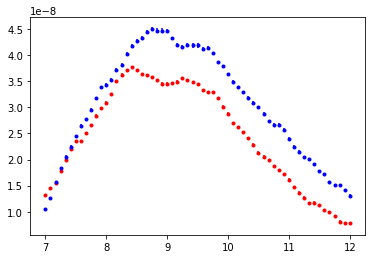

In [698]:
#plt.plot(waves,var[:,0])
plt.errorbar(waves,var1[:,0],yerr=covar1[:,0],fmt = 'r.')
plt.errorbar(waves,var2[:,0],yerr=covar2[:,0],fmt = 'b.')
plt.show()

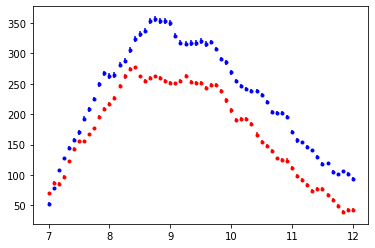

In [699]:
plt.errorbar(waves,var1[:,1],yerr=covar1[:,1],fmt = 'r.')
plt.errorbar(waves,var2[:,1],yerr=covar2[:,1],fmt = 'b.')
plt.show()

In [742]:
temp = np.linspace(-30,50,80) + 273
nedts = np.zeros([len(waves),len(temp)])
for i in range(len(waves)):
    for t in range(len(temp)):
        tem = temp[t]
        snr =  0
        delta = 0
        e = np.mean(responses_err[:,i])
        
        while snr < e:
            snr = np.abs(func(tem+delta/2,var[i,0],var[i,1])-func(tem-delta/2,var[i,0],var[i,1]))
            delta = delta +.01 

        nedts[i,t] = delta


fig = plt.gcf()
fig.set_size_inches(15, 6)
plt.contourf(waves,temp,np.transpose(nedts),55,norm=colors.PowerNorm(gamma=.9),cmap='plasma',vmax = 4.5,vmin = .4)
plt.colorbar()
plt.xlabel('Wavelength')
plt.show()

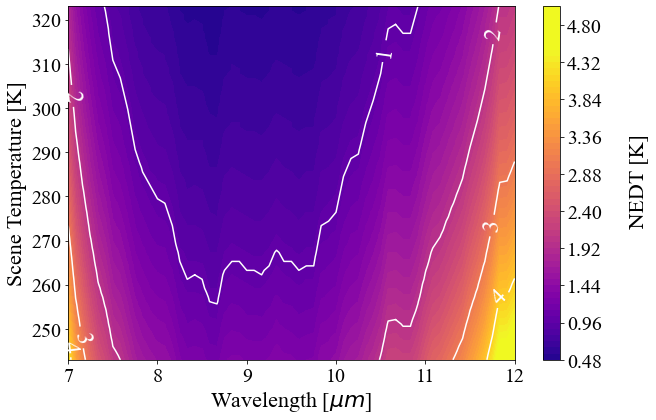

In [789]:
fig = plt.gcf() 
fig.set_size_inches(10, 6.5) 
plt.contourf(waves,temp,np.transpose(nedts),55,norm=colors.PowerNorm(gamma=.9),cmap='plasma',vmax = 4.5,vmin = .4) 
plt.colorbar(label = '\n NEDT [K]') 
plt.xlabel('Wavelength [$\mu m$]') 
plt.ylabel('Scene Temperature [K]') 
contours = plt.contour(waves,temp,np.transpose(nedts), 4, colors='white')
plt.clabel(contours, inline=True, fontsize= 24)
plt.show()

fig.savefig('/Users/kirahart/Dropbox/Publications/IEEE2021/NEDT.png',dpi = 100)

In [794]:
hf = h5py.File(path + 'LUT.h5', 'w')
hf.create_dataset('/var', data=var)
hf.create_dataset('/var1', data=var1)
hf.create_dataset('/var2', data=var2)
    

hf.create_dataset('/waves',data = waves)
hf.create_dataset('/nedt', data = nedts)
hf.create_dataset('/temp', data = temps)

hf.close()